## 0. Loading Data

In [4]:
import pandas as pd

# Load the CSV file into a DataFrame with low_memory=False to avoid DtypeWarning
data = pd.read_csv('msna_data.csv', low_memory=False)

## 1. Data Exploration

This code performs **explanatory data analysis** (EDA) on a dataset, focusing on correlation analysis, skewness, and variance inflation factor (VIF) for numeric features. It also handles label encoding of categorical variables, cross-tabulation, and hierarchical clustering for visualizing relationships between categories. Finally, the results are exported for further analysis.

**Key Steps:**

1. **Label Encoding for Categorical Variables**:
   - The function `encode_categorical_columns(df)` uses `LabelEncoder` to convert categorical variables into numeric form, ensuring that no NaN values are introduced during conversion. This step is essential for preparing the dataset for correlation and regression analysis.

2. **Correlation and Explanatory Analysis**:
   - The `explanatory_analysis(df, target)` function calculates various statistical metrics for each feature in relation to the target variable, including:
     - **Pearson correlation and p-value**.
     - **Spearman correlation and p-value**.
     - **Kendall's Tau correlation and p-value**.
     - **Skewness**: To measure asymmetry in the distribution of each feature.
     - **Variance Inflation Factor (VIF)**: To detect multicollinearity between features.

3. **Cross-Tabulation**:
   - A **cross-tabulation** of the `msna` categories and the target variable (`child_sep_severity_family_reun_required`) is created to analyze the proportion of the target values within each category.

4. **Hierarchical Clustering**:
   - **Hierarchical clustering** is performed using the `ward` linkage method on the cross-tabulated data to group `msna` categories based on the distribution of the target variable.
   - A **dendrogram** is plotted to visualize the relationships between the clusters of `msna` categories.

5. **Data Visualization**:
   - A bar plot visualizes the frequency distribution of the `msna` categories.
   - A dendrogram visualizes the hierarchical clustering of the `msna` categories based on the target distribution.

6. **Exporting Results**:
   - The correlation analysis table is saved as an Excel file (`eda_corr_table.xlsx`) for further review or documentation.

                                         Variable  Pearson Correlation  \
60    child_sep_severity_all_family_reun_required             1.000000   
9                         child_sep_reasons_given             0.225001   
5                             children_outside_hh             0.225001   
6                         children_outside_hh_all             0.225001   
55                        children_outside_hh_yes             0.225001   
..                                            ...                  ...   
61  child_sep_severity_all_no_children_outside_hh            -0.225001   
58      child_sep_severity_no_children_outside_hh            -0.225001   
56                     children_outside_hh_all_no            -0.225001   
8                          child_sep_severity_all            -0.459017   
7                              child_sep_severity            -0.459017   

    Pearson P-Value  Spearman Correlation  Spearman P-Value  \
60              0.0              1.000000       

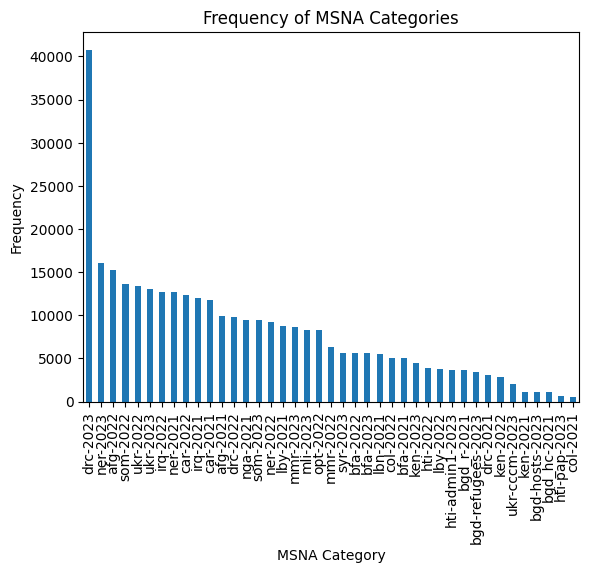

Explanatory Test: Cross-tabulation of msna categories and target values
child_sep_severity_family_reun_required       0.0       1.0
msna                                                       
afg-2021                                 0.999262  0.000738
afg-2022                                 0.999869  0.000131
bfa-2021                                 0.996712  0.003288
bfa-2022                                 0.997073  0.002927
bfa-2023                                 0.997325  0.002675
bgd-hosts-2023                           1.000000  0.000000
bgd-refugees-2023                        0.997026  0.002974
bgd_hc-2021                              0.999040  0.000960
bgd_r-2021                               0.999707  0.000293
car-2021                                 0.958882  0.041118
car-2022                                 0.995492  0.004508
col-2022                                 0.999729  0.000271
drc-2021                                 0.996414  0.003586
drc-2022                    

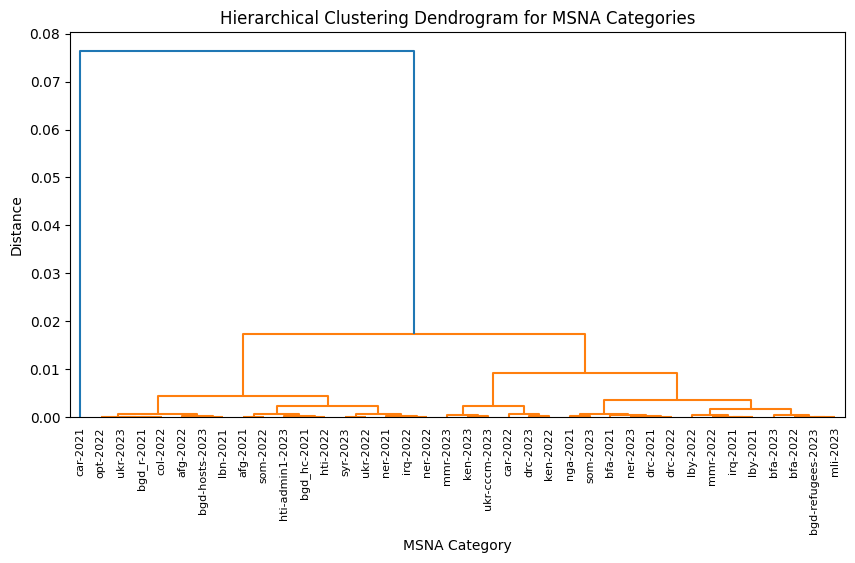

In [5]:
import missingno as msno
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr, spearmanr, kendalltau, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

# Label encode any categorical variables to ensure no NaNs during conversion
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns before converting them to numeric
def encode_categorical_columns(df):
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    return df

# Apply encoding to categorical columns
encoded_data = encode_categorical_columns(data.copy())

# Now convert to numeric (this step will not introduce NaNs because categorical columns are now encoded)
numeric_data = encoded_data.apply(pd.to_numeric, errors='coerce')

# Function to calculate correlations, p-values, and other explanatory metrics
def explanatory_analysis(df, target):
    variables = df.columns[df.columns != target]
    results = {
        'Variable': [],
        'Pearson Correlation': [],
        'Pearson P-Value': [],
        'Spearman Correlation': [],
        'Spearman P-Value': [],
        'Kendall Tau Correlation': [],
        'Kendall P-Value': [],
        'Skewness': [],
        'Variance Inflation Factor (VIF)': []
    }

    for col in variables:
        clean_df = df[[col, target]].dropna()

        # Check if the column has enough variability (at least 2 unique values)
        if len(clean_df) >= 2 and clean_df[col].nunique() > 1 and clean_df[target].nunique() > 1:
            # Pearson correlation and p-value
            pearson_corr, pearson_p = pearsonr(clean_df[col], clean_df[target])

            # Spearman correlation and p-value (only if there's variability)
            spearman_corr, spearman_p = spearmanr(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Kendall's Tau correlation and p-value (only if there's variability)
            kendall_corr, kendall_p = kendalltau(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Skewness (calculate only if variability exists)
            skewness = skew(clean_df[col]) if clean_df[col].nunique() > 1 else np.nan

            # VIF calculation (handled similarly)
            try:
                vif = variance_inflation_factor(df.dropna().values, df.columns.get_loc(col))
            except:
                vif = np.nan  # Handle cases where VIF cannot be computed

            # Append results to the appropriate lists
            results['Variable'].append(col)
            results['Pearson Correlation'].append(pearson_corr)
            results['Pearson P-Value'].append(pearson_p)
            results['Spearman Correlation'].append(spearman_corr)
            results['Spearman P-Value'].append(spearman_p)
            results['Kendall Tau Correlation'].append(kendall_corr)
            results['Kendall P-Value'].append(kendall_p)
            results['Skewness'].append(skewness)
            results['Variance Inflation Factor (VIF)'].append(vif)

    # Return the results as a DataFrame
    return pd.DataFrame(results).sort_values(by='Pearson Correlation', ascending=False)

# Apply the function for explanatory analysis on all numeric variables
explanatory_table = explanatory_analysis(numeric_data, 'child_sep_severity_family_reun_required')

# Print the explanatory analysis table
print(explanatory_table)

# Export the DataFrame to an Excel file
explanatory_table.to_excel("eda_corr_table.xlsx", index=False)

# Check the frequency of each category in 'msna'
msna_freq = data['msna'].value_counts()

# Print the frequency of each category in msna
print("Frequency of each category in 'msna':")
print(msna_freq)

# Visualize the distribution of msna categories
msna_freq.plot(kind='bar')
plt.title('Frequency of MSNA Categories')
plt.xlabel('MSNA Category')
plt.ylabel('Frequency')
plt.show()

# Cross-tabulation of msna categories and target values
print("Explanatory Test: Cross-tabulation of msna categories and target values")
target_dist_by_msna = pd.crosstab(data['msna'], data['child_sep_severity_family_reun_required'], normalize='index')
print(target_dist_by_msna)

# Check the structure of the input data (proportion of target variable for each msna category)
print("Explanatory Test: Structure of the input data (proportion of target variable for each msna category)")
print(target_dist_by_msna.head())

# Perform hierarchical clustering using the linkage matrix
linkage_matrix = linkage(target_dist_by_msna, method='ward')

# Plot the dendrogram to visualize category clustering
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=target_dist_by_msna.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram for MSNA Categories')
plt.xlabel('MSNA Category')
plt.ylabel('Distance')
plt.show()

## 2. Data Cleaning

This script cleans and prepares a dataset for analysis by handling missing data, dropping irrelevant columns, and visualizing the changes.

**Key Steps**

1. **Import Libraries**: Uses `pandas`, `matplotlib.pyplot`, and `missingno` for data manipulation and visualization.
2. **Drop Columns with Conditions**: Defines a function to drop columns based on missing values, zero variance, or specific patterns.
3. **Filter Data**: Removes rows with missing values in the `child_sep_severity` column.
4. **Select Variables**: Loads pre-selected variables from `vars_analysis.csv` and drops aggregated age columns.
5. **Handle Missing Values**: Drops columns with >20% missing data and columns with zero variance.
6. **Remove '_NA' Columns**: Drops columns ending with '_NA'.
7. **Visualize Missing Data**: Visualizes missing data before and after column removal.
8. **Final DataFrame Info**: Prints the final cleaned DataFrame structure.


Shape of the filtered DataFrame, without missing values for the response variable: (268511, 199)

Dropped columns with more than 20% missing values:
['lcsi_cat', 'hoh_age', 'rcsi_score', 'fsl_fc_cell', 'wgq_dis_4_n', 'wgq_dis_3_n', 'wgq_dis_2_n', 'fatalities_3m', 'events_3m', 'fatalities_6m', 'events_6m', 'fatalities_1y', 'events_1y', 'displ_status_specific_idp_non_site', 'displ_status_specific_idp_returnee', 'displ_status_specific_idp_site', 'received_assistance_3m_dnk', 'received_assistance_3m_dwta', 'received_assistance_3m_no', 'received_assistance_3m_yes', 'received_assistance_6m_dnk', 'received_assistance_6m_dwta', 'received_assistance_6m_no', 'received_assistance_6m_yes', 'received_assistance_12m_dnk', 'received_assistance_12m_dwta', 'received_assistance_12m_no', 'received_assistance_12m_yes']

Dropped columns '_NA' columns:
['displ_status_general_NA', 'displ_status_specific_NA', 'hoh_gender_NA', 'single_caregiver_NA', 'received_assistance_3m_NA', 'received_assistance_6m_NA', 'r

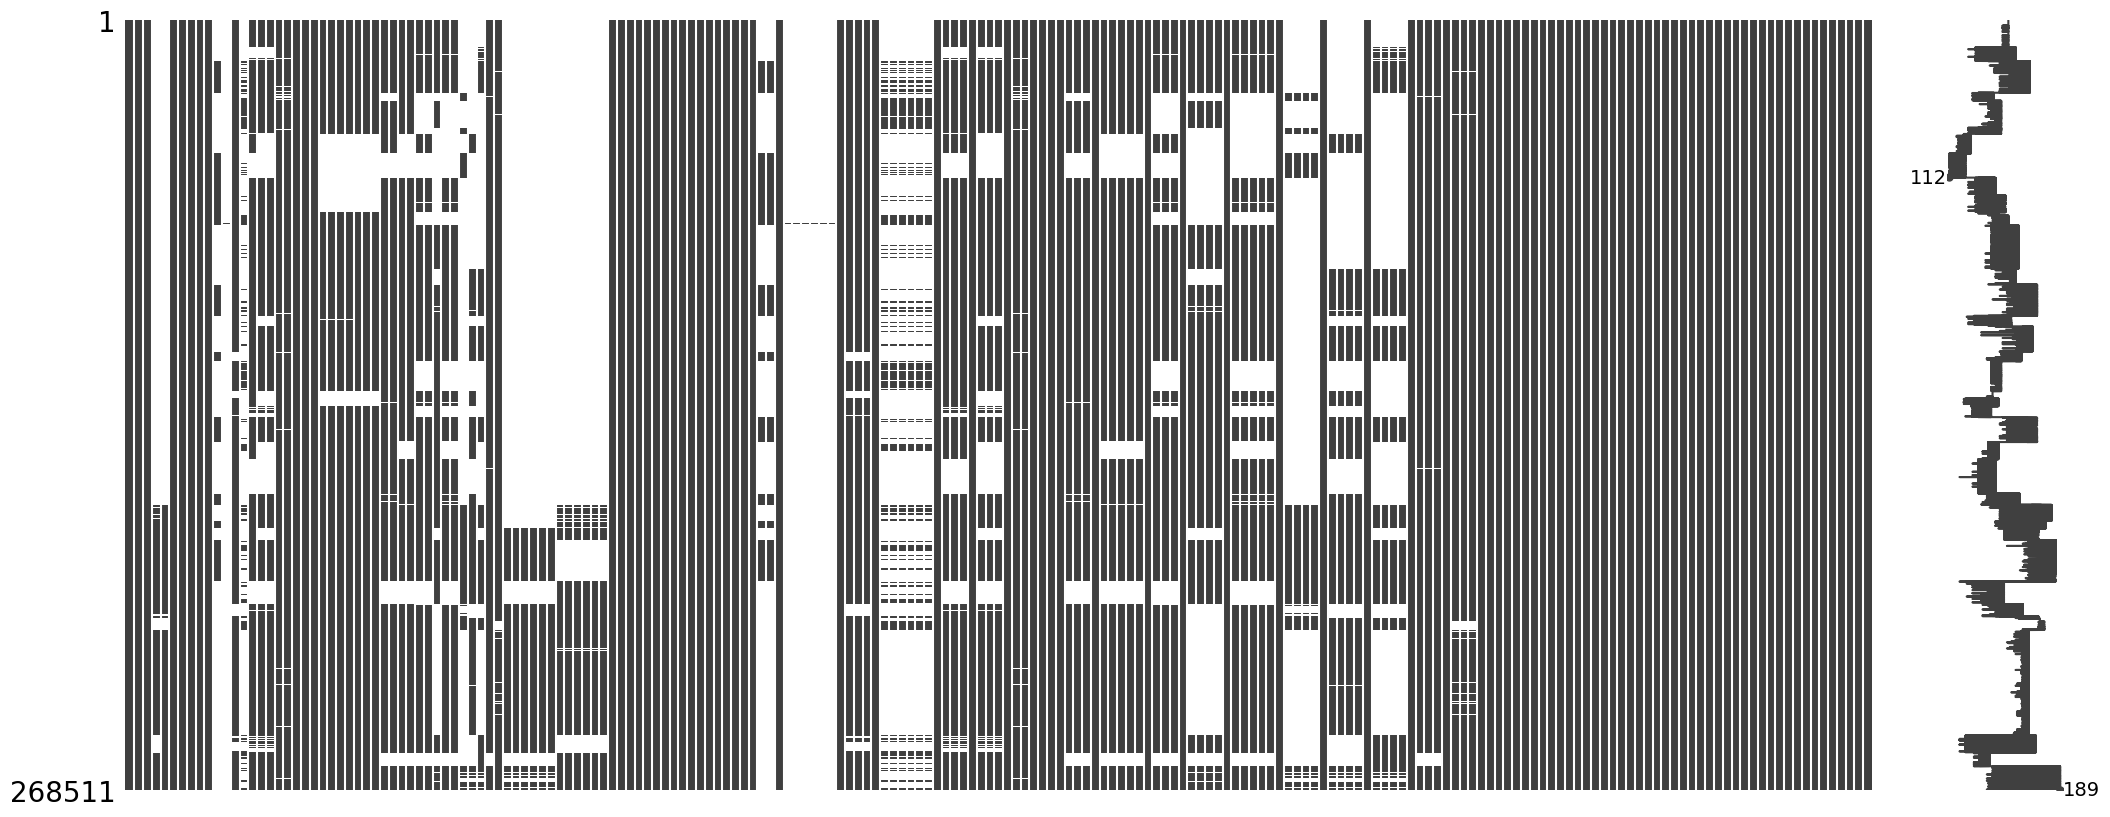

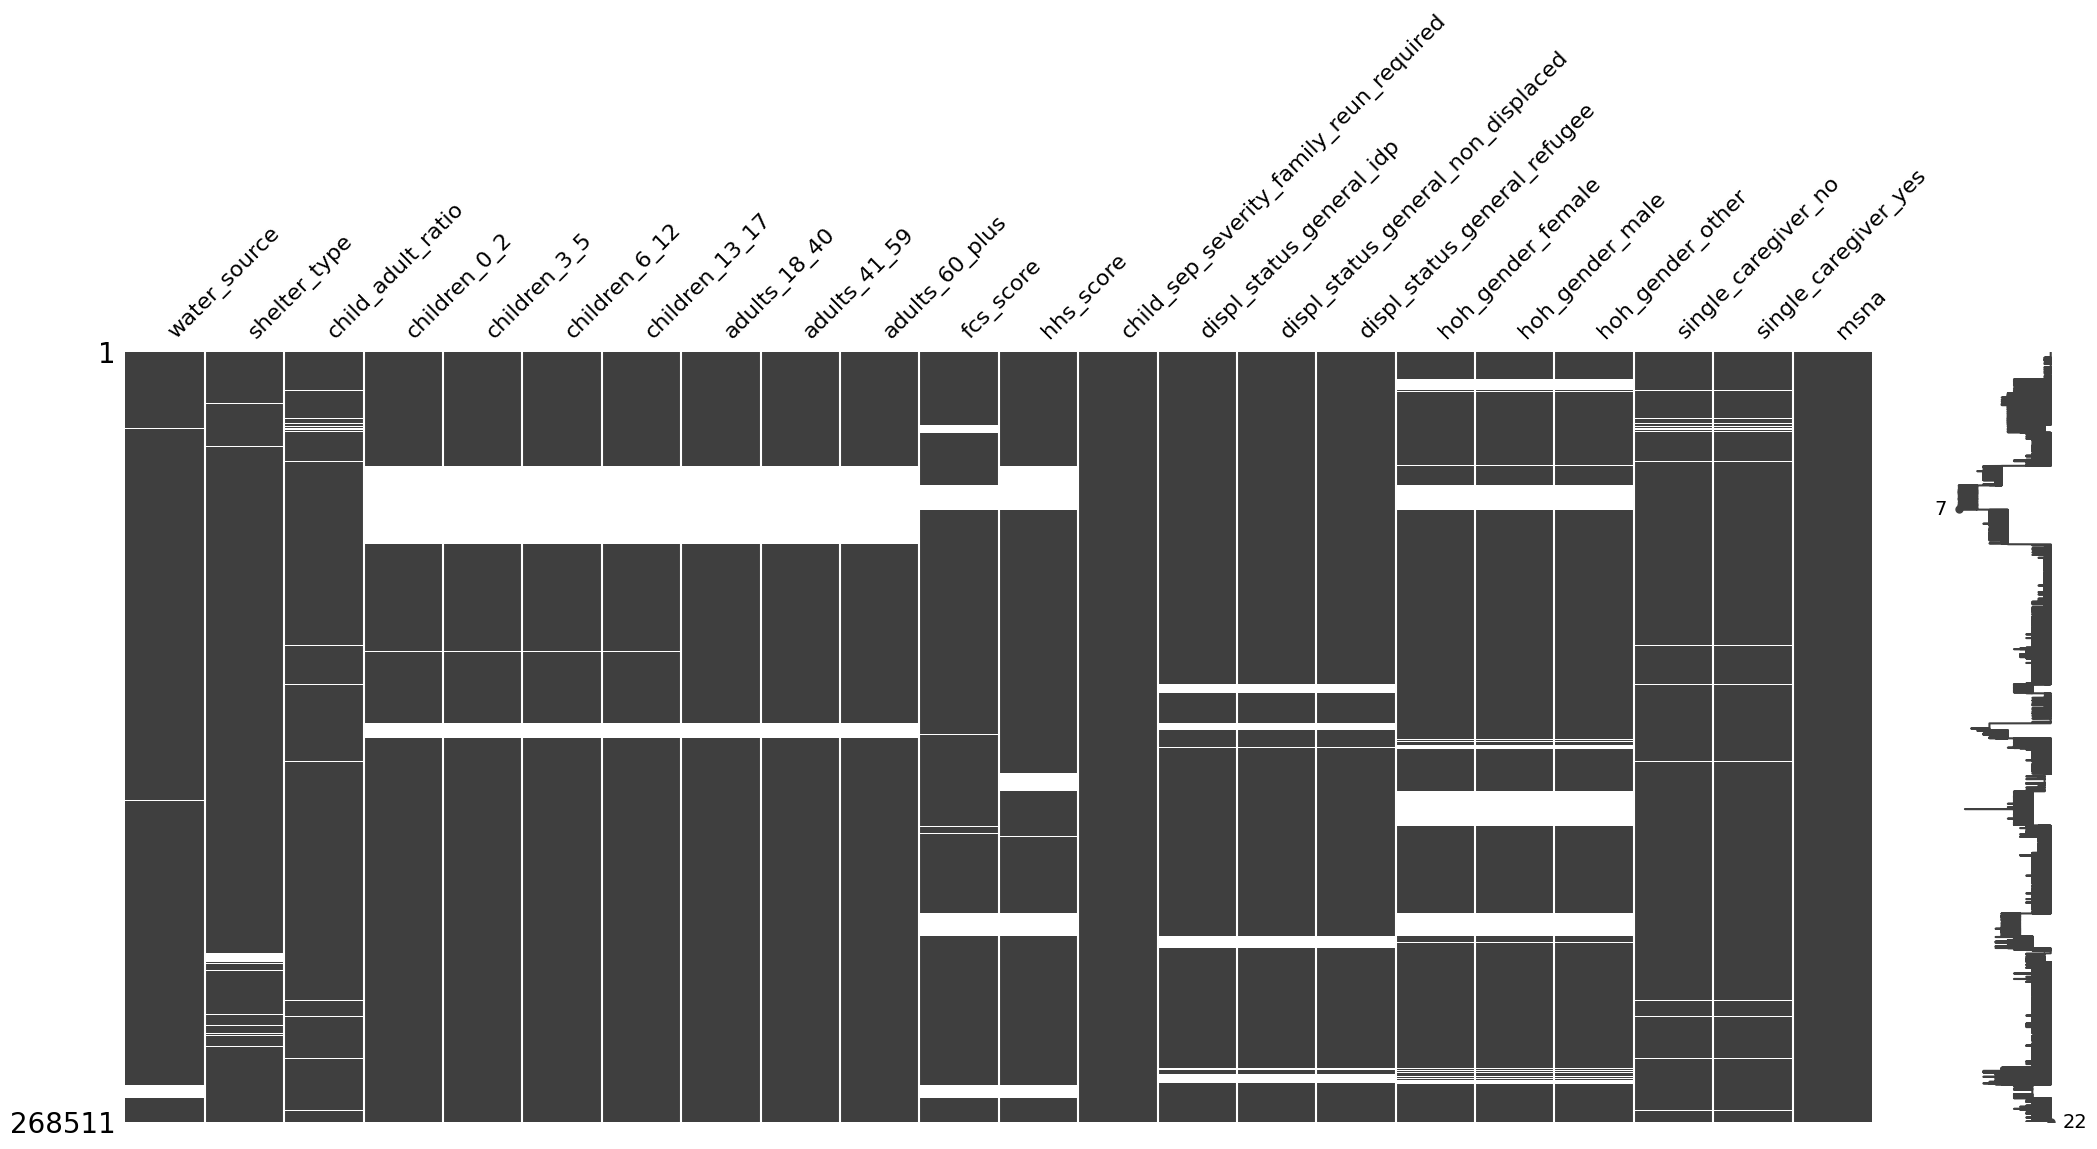


Final DataFrame after dropping unnecessary columns:
<class 'pandas.core.frame.DataFrame'>
Index: 268511 entries, 0 to 329442
Data columns (total 22 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   water_source                             263014 non-null  object 
 1   shelter_type                             262333 non-null  object 
 2   child_adult_ratio                        264081 non-null  float64
 3   children_0_2                             235209 non-null  float64
 4   children_3_5                             235209 non-null  float64
 5   children_6_12                            235209 non-null  float64
 6   children_13_17                           235209 non-null  float64
 7   adults_18_40                             235498 non-null  float64
 8   adults_41_59                             235498 non-null  float64
 9   adults_60_plus                           235498 non-nul

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# Define function to display and drop columns based on a condition
def drop_columns_with_condition(df, condition, description):
    columns_to_drop = df.columns[condition].tolist()
    if columns_to_drop:
        print(f"\nDropped columns {description}:")
        print(columns_to_drop)
        return df.drop(columns=columns_to_drop)
    return df

# Filter out rows with missing values in the 'child_sep_severity' column
data_filtered = data.dropna(subset=['child_sep_severity'])
print("\nShape of the filtered DataFrame, without missing values for the response variable:", data_filtered.shape)

# Load variables to consider for the model
vars_analysis = pd.read_csv('vars_analysis.csv')['variable'].tolist()

# Select columns that were pre-selected for analysis and present in the dataset
data_select = data_filtered[vars_analysis].copy()

# Exclude the two aggregated age variables
aggregate_features = ['num_children', 'num_adults']
data_select = data_select.drop(columns=aggregate_features, errors='ignore')

# Identify columns with more than 20% missing values
missing_percentage = data_select.isnull().mean() * 100
columns_with_many_missing = missing_percentage > 20

# Drop columns with more than 20% missing values
data_select = drop_columns_with_condition(data_select, columns_with_many_missing, "with more than 20% missing values")

# Drop columns with zero variance (only one unique value)
zero_variance_condition = data_select.nunique() <= 1
data_select = drop_columns_with_condition(data_select, zero_variance_condition, "with zero variance")

# Identify and drop variables ending with '_NA'
na_columns = [col for col in data_select.columns if col.endswith('_NA')]
data_select = drop_columns_with_condition(data_select, data_select.columns.isin(na_columns), "'_NA' columns")

# Visualize missing data matrix before and after dropping columns
msno.matrix(data_filtered)
plt.show()
msno.matrix(data_select)
plt.show()

# Display final DataFrame info
print("\nFinal DataFrame after dropping unnecessary columns:")
data_select.info()


## 3. Feature Engineering 

In [7]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering

# Load the new_labels CSV file and filter for variables present in the data
new_labels = pd.read_csv('new_labels.csv', usecols=['variable', 'label_old', 'label_new'])
new_labels = new_labels[new_labels['variable'].isin(data_select.columns)]

# Create a copy of data_select to apply changes
data_trans = data_select.copy()

# Apply the label mapping to the data_trans DataFrame
for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])  # Convert label_new to integer
    
    if variable in data_trans.columns:
        data_trans[variable] = data_trans[variable].replace(label_old, label_new)

# Define recoded_variables
recoded_variables = new_labels['variable'].unique()

# Convert the recoded variables to integer type
for variable in recoded_variables:
    if variable in data_trans.columns:
        data_trans[variable] = data_trans[variable].fillna(pd.NA).astype('Int64')

# Clustering MSNA variables using AgglomerativeClustering
n_clusters = 5
cluster_model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
msna_clusters = cluster_model.fit_predict(target_dist_by_msna)

# Create a DataFrame to show the MSNA categories and their corresponding clusters
clustered_df = pd.DataFrame({'msna': target_dist_by_msna.index, 'cluster': msna_clusters})

# Map cluster assignments back to the original DataFrame
msna_cluster_map = clustered_df.set_index('msna')['cluster'].to_dict()
data_trans['msna_clustered'] = data_trans['msna'].map(msna_cluster_map)

# Replace the original 'msna' column and One-hot encode the 'msna' column
data_trans['msna'] = data_trans['msna_clustered']
data_trans = data_trans.drop(columns=['msna_clustered'])
data_trans = pd.get_dummies(data_trans, columns=['msna'], prefix='msna', dtype=int)

print("\nTransformed DataFrame after label encoding and clustering:")
print(data_trans.head())


Transformed DataFrame after label encoding and clustering:
   water_source  shelter_type  child_adult_ratio  children_0_2  children_3_5  \
0             1             1                0.2           0.0           0.0   
1             1             1                2.5           0.0           1.0   
3             1             1                2.0           1.0           1.0   
4             1             1                2.0           0.0           0.0   
6             2             1                2.5           0.0           2.0   

   children_6_12  children_13_17  adults_18_40  adults_41_59  adults_60_plus  \
0            0.0             1.0           3.0           2.0             0.0   
1            4.0             0.0           1.0           1.0             0.0   
3            2.0             0.0           2.0           0.0             0.0   
4            4.0             0.0           1.0           1.0             0.0   
6            2.0             1.0           0.0           2.

C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_30756\3136967616.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_trans[variable] = data_trans[variable].replace(label_old, label_new)


## 4. Imputation of Missing Values


In [ ]:
import pandas as pd
import pickle
from sklearn.impute import KNNImputer
import missingno as msno
import matplotlib.pyplot as plt

# Function to apply K-Nearest Neighbors Imputation to all columns
def knn_impute_all_columns(df, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df_imputed

# Apply KNN imputation to all columns
data_na_imp = knn_impute_all_columns(data_trans.copy())

# Visualize missing data matrix after imputation
msno.matrix(data_na_imp)
plt.show()

# Display the first few rows of the new dataframe with imputed values
print("\nDataFrame with imputed values:")
print(data_na_imp.head())

# Saving the DataFrame as a pickle file
with open('data_na_imp.pkl', 'wb') as f:
    pickle.dump(data_na_imp, f)


## 5. Data Standardization


Summary statistics before standardization:
        water_source   shelter_type  child_adult_ratio   children_0_2  \
count  268511.000000  268511.000000      268511.000000  268511.000000   
mean        1.303494       1.240512           1.517225       0.458774   
std         0.576704       0.441943           1.122010       0.666187   
min         1.000000       1.000000           0.035714       0.000000   
25%         1.000000       1.000000           0.666667       0.000000   
50%         1.000000       1.000000           1.333333       0.000000   
75%         1.000000       1.000000           2.000000       1.000000   
max         3.000000       3.000000          14.000000      12.000000   

        children_3_5  children_6_12  children_13_17   adults_18_40  \
count  268511.000000  268511.000000   268511.000000  268511.000000   
mean        0.623481       1.424800        0.768818       1.841805   
std         0.732188       1.238367        0.914277       1.159341   
min         0.0000

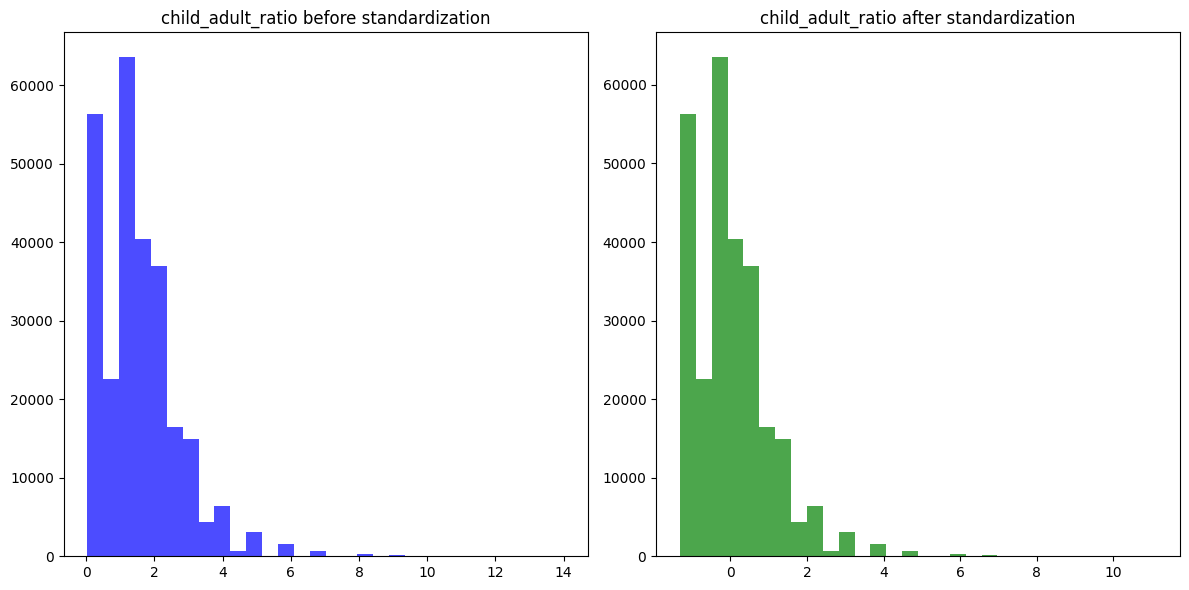

In [2]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Loading the DataFrame back from the pickle file
with open('data_na_imp.pkl', 'rb') as f:
    data_na_imp = pickle.load(f)
    
# Load the vars_analysis.csv to identify variable types
vars_analysis = pd.read_csv('vars_analysis.csv', usecols=['variable', 'type'])
numerical_variables = vars_analysis[vars_analysis['type'] == 'numerical']['variable'].tolist()

# Standardize the numerical variables
scaler = StandardScaler()
data_stand = data_na_imp.copy()

# Filter numerical variables that are present in the DataFrame
numerical_variables = [var for var in numerical_variables if var in data_stand.columns]

# Apply standardization only to numerical variables
data_stand[numerical_variables] = scaler.fit_transform(data_stand[numerical_variables])

# Display summary statistics before and after standardization
print("\nSummary statistics before standardization:")
print(data_na_imp.describe())
print("\nSummary statistics after standardization:")
print(data_stand.describe())

# Display histograms before and after standardization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data_na_imp['child_adult_ratio'], bins=30, alpha=0.7, color='blue')
plt.title('child_adult_ratio before standardization')

plt.subplot(1, 2, 2)
plt.hist(data_stand['child_adult_ratio'], bins=30, alpha=0.7, color='green')
plt.title('child_adult_ratio after standardization')
plt.tight_layout()
plt.show()

## 6. Feature Selection


Dropping 2 highly correlated features: ['hoh_gender_male', 'single_caregiver_yes']
[LightGBM] [Info] Number of positive: 793, number of negative: 187164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 187957, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

LightGBM model trained. Feature importances:
[ 75 106 304 160 145 212 198 204 145  89 671 185  47  66  31  79   0  39
  40  43  41  82  38]



c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


Shape of shap_values: (187957, 23)

=== SHAP Feature Importance ===
             feature  shap_importance
0       water_source         0.076991
1       shelter_type         0.074254
2  child_adult_ratio         0.134888
3       children_0_2         0.190391
4       children_3_5         0.123871

Top 20 features by SHAP values: ['msna_4', 'fcs_score', 'msna_2', 'msna_3', 'msna_1', 'children_6_12', 'displ_status_general_non_displaced', 'children_0_2', 'adults_41_59', 'child_adult_ratio', 'children_3_5', 'children_13_17', 'hhs_score', 'adults_18_40', 'water_source', 'hoh_gender_female', 'shelter_type', 'msna_0', 'adults_60_plus', 'single_caregiver_no']

All top features are present in X_uncorr.

X_selected contains exactly the top features.


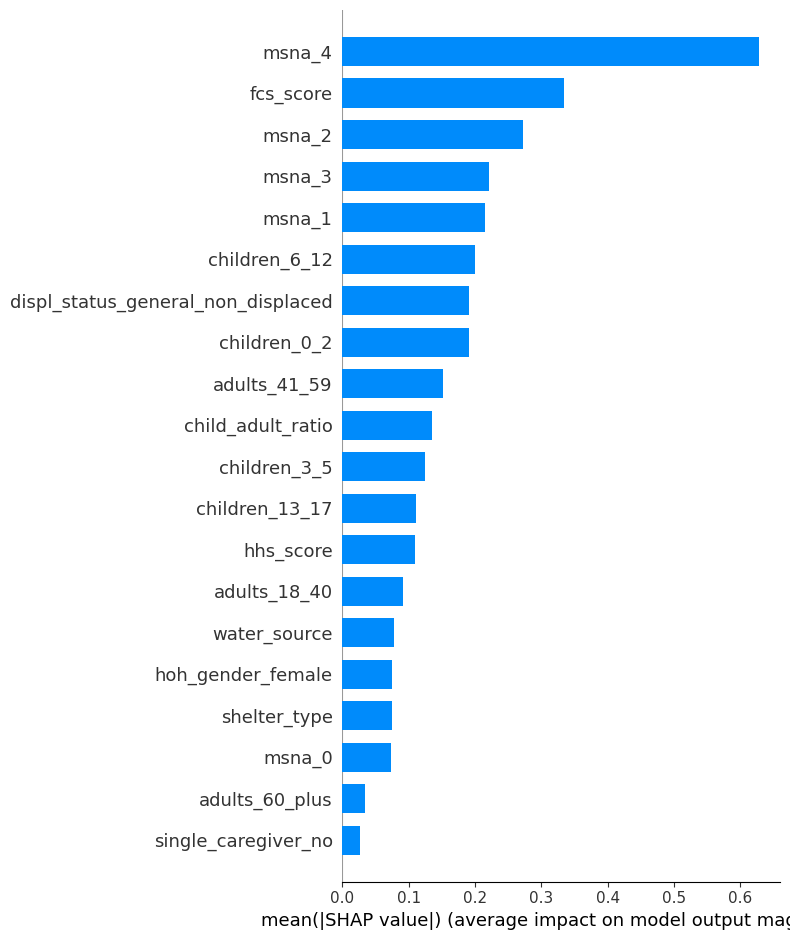

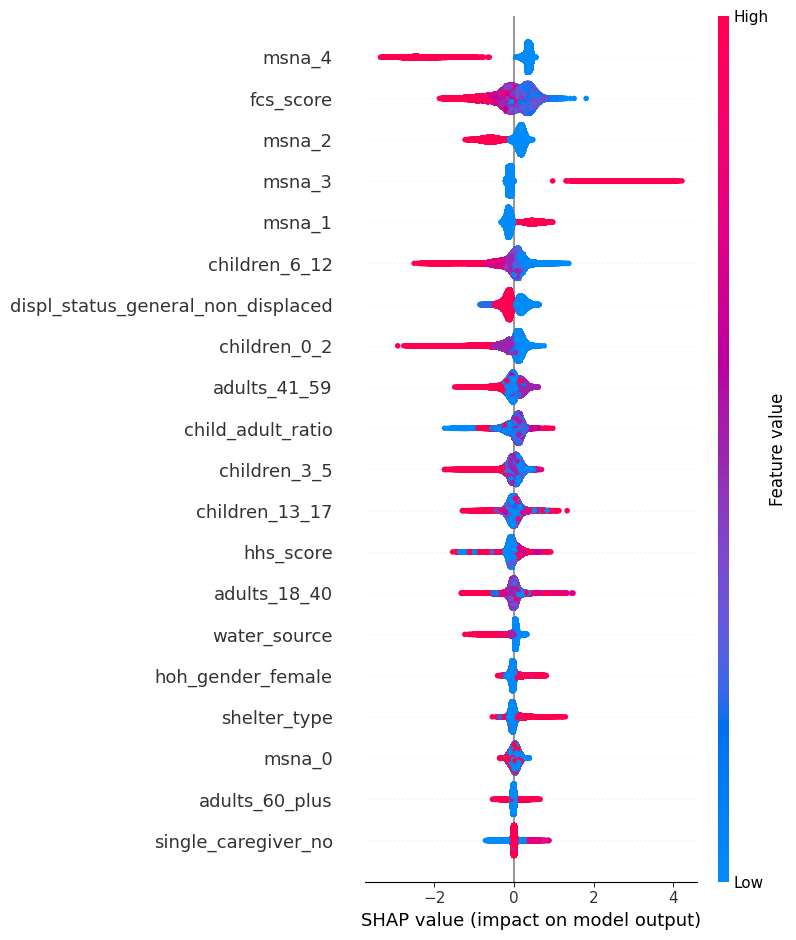

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Ensure that data_stand is defined before running this script
data_fs = data_stand.copy()

# Separate features and target variable
target_column = 'child_sep_severity_family_reun_required'
if target_column not in data_fs.columns:
    raise KeyError(f"Target column '{target_column}' not found in data.")

X = data_fs.drop(columns=[target_column])
y = data_fs[target_column]

# Ensure input data is correct (numeric, no missing values)
def check_numeric(df):
    non_numeric = df.columns[~df.dtypes.apply(lambda x: np.issubdtype(x, np.number))]
    if len(non_numeric) > 0:
        raise ValueError(f"Non-numeric columns detected: {list(non_numeric)}. Please convert them to numeric format.")

def check_no_missing(df):
    missing = df.columns[df.isnull().any()]
    if len(missing) > 0:
        raise ValueError(f"Missing values found in columns: {list(missing)}. Please handle missing data before proceeding.")

check_numeric(X)
check_no_missing(X)

# Correlation Analysis to remove highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

correlation_threshold = 0.9  # Adjust if needed
to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
X_uncorr = X.drop(columns=to_drop)

if to_drop:
    print(f"\nDropping {len(to_drop)} highly correlated features: {to_drop}")
else:
    print("\nNo highly correlated features found to drop.")

# Ensure enough features remain after removing correlated ones
if X_uncorr.shape[1] == 0:
    raise ValueError("No features remaining after removing highly correlated ones.")

# Train-test split for SHAP analysis
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
    X_uncorr, y, test_size=0.3, random_state=42, stratify=y
)

# Train a LightGBM model for SHAP analysis
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgb_model.fit(X_temp_train, y_temp_train)

# Debugging: Check model fit
print(f"\nLightGBM model trained. Feature importances:\n{lgb_model.feature_importances_}\n")

# Create the SHAP explainer without passing data
explainer = shap.TreeExplainer(lgb_model)

# Compute SHAP values with check_additivity=False
shap_values = explainer.shap_values(X_temp_train, check_additivity=False)

if isinstance(shap_values, list):
    # For binary classification, shap_values is a list with two arrays
    print(f"Length of shap_values list: {len(shap_values)}")
    print(f"Shape of SHAP values for class 0: {shap_values[0].shape}")
    print(f"Shape of SHAP values for class 1: {shap_values[1].shape}")
    # Select the SHAP values for the positive class
    shap_values_selected = shap_values[1]
else:
    # For binary classification in newer versions, shap_values is an array
    print(f"Shape of shap_values: {shap_values.shape}")
    shap_values_selected = shap_values

# Verify that the SHAP values match the shape of the input feature matrix
assert shap_values_selected.shape == X_temp_train.shape, \
    f"Mismatch: SHAP values shape {shap_values_selected.shape} and input shape {X_temp_train.shape}"

# Calculate SHAP feature importance based on mean absolute SHAP values
mean_abs_shap_values = np.abs(shap_values_selected).mean(axis=0)
shap_importance = pd.DataFrame({
    'feature': X_uncorr.columns,
    'shap_importance': mean_abs_shap_values
})

# Debugging: Check SHAP feature importance
print("\n=== SHAP Feature Importance ===")
print(shap_importance.head())

shap_importance.sort_values(by='shap_importance', ascending=False, inplace=True)

# Select top features based on SHAP values
num_top_features = 20
top_features_shap = shap_importance['feature'].head(num_top_features).tolist()

# Debugging: Check selected top features
print(f"\nTop {num_top_features} features by SHAP values: {top_features_shap}")

# Verify that the top features are present in X_uncorr
missing_features = set(top_features_shap) - set(X_uncorr.columns)
if missing_features:
    print(f"\nError: The following top features are not present in X_uncorr: {missing_features}")
else:
    print("\nAll top features are present in X_uncorr.")

# Save the selected features
X_selected = X_uncorr[top_features_shap]

# Verify that X_selected contains only the top features
selected_features_set = set(top_features_shap)
x_selected_features_set = set(X_selected.columns)
if selected_features_set == x_selected_features_set:
    print("\nX_selected contains exactly the top features.")
else:
    missing = selected_features_set - x_selected_features_set
    extra = x_selected_features_set - selected_features_set
    if missing:
        print(f"\nError: The following top features are missing in X_selected: {missing}")
    if extra:
        print(f"\nError: The following extra features are present in X_selected: {extra}")

# Save the selected features to a pickle file
X_selected.to_pickle('X_selected.pkl')

# Subset the SHAP values to include only the top features
# Convert shap_values_selected to a DataFrame for easy manipulation
shap_values_df = pd.DataFrame(shap_values_selected, columns=X_uncorr.columns)

# Extract SHAP values for the top features
shap_values_selected_top = shap_values_df[top_features_shap].values

# Ensure that the subset SHAP values match the selected features' shape
assert shap_values_selected_top.shape[1] == len(top_features_shap), \
    f"Mismatch after subsetting: SHAP values have {shap_values_selected_top.shape[1]} features, expected {len(top_features_shap)}"

# SHAP summary plots for the selected SHAP values
# Bar plot
shap.summary_plot(
    shap_values_selected_top, 
    X_temp_train[top_features_shap], 
    plot_type="bar", 
    max_display=num_top_features,
    show=False
)
plt.savefig('fs_shap_summary_bar.png', bbox_inches='tight')
plt.show()
plt.close()

# Detailed summary plot
shap.summary_plot(
    shap_values_selected_top, 
    X_temp_train[top_features_shap], 
    max_display=num_top_features,
    show=False
)
plt.savefig('fs_shap_summary.png', bbox_inches='tight')
plt.show()
plt.close()



## 7. Data Splitting

In [4]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the saved DataFrames
with open('X_selected.pkl', 'rb') as f:
    X_selected = pickle.load(f)
with open('y.pkl', 'rb') as f:
    y = pickle.load(f)

### 1. Separate the Data into Class 0 (Normal) and Class 1 (Anomalies) ###
# Create DataFrames for class 0 (normal cases) and class 1 (anomalies)
X_class0 = X_selected[y == 0]
y_class0 = y[y == 0]

X_class1 = X_selected[y == 1]
y_class1 = y[y == 1]

print(f"Total samples in Class 0 (Normal): {X_class0.shape[0]}")
print(f"Total samples in Class 1 (Anomalies): {X_class1.shape[0]}")

### 2. Split Class 0 Data into Training, Validation, and Test Sets ###
# Split class 0 data into training (80%) and temporary set (20%)
X_train_class0, X_temp_class0, y_train_class0, y_temp_class0 = train_test_split(
    X_class0, y_class0, test_size=0.2, random_state=42
)

# Further split the temporary class 0 data into validation (10%) and test (10%) sets
X_val_class0, X_test_class0, y_val_class0, y_test_class0 = train_test_split(
    X_temp_class0, y_temp_class0, test_size=0.5, random_state=42
)

print("\nClass 0 Data Splits:")
print(f"  Training samples: {X_train_class0.shape[0]}")
print(f"  Validation samples: {X_val_class0.shape[0]}")
print(f"  Test samples: {X_test_class0.shape[0]}")

### 3. Split Class 1 Data (Anomalies) into Validation and Test Sets ###
# Since we don't use anomalies for training, split class 1 data into validation and test sets
X_val_class1, X_test_class1, y_val_class1, y_test_class1 = train_test_split(
    X_class1, y_class1, test_size=0.5, random_state=42
)

print("\nClass 1 Data Splits (Anomalies):")
print(f"  Validation samples: {X_val_class1.shape[0]}")
print(f"  Test samples: {X_test_class1.shape[0]}")

### 4. Combine Class 0 and Class 1 Data for Validation and Test Sets ###
# Validation Set: Combine class 0 and class 1 validation data
X_val = pd.concat([X_val_class0, X_val_class1])
y_val = pd.concat([y_val_class0, y_val_class1])

# Test Set: Combine class 0 and class 1 test data
X_test = pd.concat([X_test_class0, X_test_class1])
y_test = pd.concat([y_test_class0, y_test_class1])

# Save the validation and test data as pickle files
with open('X_val.pkl', 'wb') as f:
    pickle.dump(X_val, f)
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# Ensure the indices are aligned
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### 5. Set Training Data (Only Class 0) ###
# Training set contains only class 0 (normal cases)
X_train = X_train_class0
y_train = y_train_class0

# Save the training data as pickle files
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

### 6. Print the Structure of the Resulting Splits ###
print("\nTraining Set (Only Class 0 - Normal Cases)")
print(f"  Features: {X_train.shape[1]}")
print(f"  Samples: {X_train.shape[0]}")
print(f"  Class 0: {np.sum(y_train == 0)}")
print(f"  Class 1: {np.sum(y_train == 1)}")  # Should be 0

print("\nValidation Set (Class 0 and Class 1)")
print(f"  Features: {X_val.shape[1]}")
print(f"  Samples: {X_val.shape[0]}")
print(f"  Class 0: {np.sum(y_val == 0)}")
print(f"  Class 1: {np.sum(y_val == 1)}")

print("\nTest Set (Class 0 and Class 1)")
print(f"  Features: {X_test.shape[1]}")
print(f"  Samples: {X_test.shape[0]}")
print(f"  Class 0: {np.sum(y_test == 0)}")
print(f"  Class 1: {np.sum(y_test == 1)}")

Total samples in Class 0 (Normal): 267378
Total samples in Class 1 (Anomalies): 1133

Class 0 Data Splits:
  Training samples: 213902
  Validation samples: 26738
  Test samples: 26738

Class 1 Data Splits (Anomalies):
  Validation samples: 566
  Test samples: 567

Training Set (Only Class 0 - Normal Cases)
  Features: 20
  Samples: 213902
  Class 0: 213902
  Class 1: 0

Validation Set (Class 0 and Class 1)
  Features: 20
  Samples: 27304
  Class 0: 26738
  Class 1: 566

Test Set (Class 0 and Class 1)
  Features: 20
  Samples: 27305
  Class 0: 26738
  Class 1: 567


## 8. Model Training

In [7]:
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

# Expanded hyperparameter grids for more robust tuning
param_grid_ocsvm = {
    'kernel': ['rbf'],  # Focus on the 'rbf' kernel
    'nu': [0.01, 0.05, 0.1],  # More values for `nu` to improve robustness
    'gamma': ['scale', 'auto']  # Include 'auto' as an additional option
}

param_grid_isolation_forest = {
    'n_estimators': [50, 100, 200, 300],  # Wider range of estimators
    'max_samples': [0.6, 0.8, 1.0],  # Add variability to max samples
    'contamination': [0.01, 0.05, 0.1],  # Slightly broader contamination values
    'bootstrap': [False, True]  # Include bootstrap as an option for flexibility
}

# Load training data (normal class only)
def load_training_data():
    with open('X_train.pkl', 'rb') as f:
        X_train = pickle.load(f)
    return X_train

# Tune and train One-Class SVM with RandomizedSearchCV
def train_ocsvm(X_train):
    ocsvm = OneClassSVM()
    randomized_search = RandomizedSearchCV(
        ocsvm, param_distributions=param_grid_ocsvm, 
        cv=2, scoring='accuracy',  # No stratified cross-validation, just 2-fold CV
        n_iter=5,  # Slightly increased n_iter for more robust tuning
        verbose=1, n_jobs=-1
    )
    randomized_search.fit(X_train)
    return randomized_search.best_estimator_

# Tune and train Isolation Forest with HalvingRandomSearchCV
def train_isolation_forest(X_train):
    iso_forest = IsolationForest(random_state=42)
    halving_search = HalvingRandomSearchCV(
        iso_forest, param_distributions=param_grid_isolation_forest,
        factor=2,  # Halving factor for efficient tuning
        cv=2,  # General cross-validation without stratification
        scoring='accuracy',  # No stratified cross-validation
        verbose=1, n_jobs=-1
    )
    halving_search.fit(X_train)
    return halving_search.best_estimator_

# Save trained models
def save_trained_models(models, filename='trained_models.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(models, f)

if __name__ == '__main__':
    # Load and train models
    X_train = load_training_data()

    # Train One-Class SVM and Isolation Forest with improved grids
    best_ocsvm = train_ocsvm(X_train)
    best_iso_forest = train_isolation_forest(X_train)

    # Save the models
    save_trained_models({'OneClassSVM': best_ocsvm, 'IsolationForest': best_iso_forest})


Fitting 2 folds for each of 5 candidates, totalling 10 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 16
min_resources_: 4
max_resources_: 213902
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 72
n_resources: 4
Fitting 2 folds for each of 72 candidates, totalling 144 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 72 is smaller than n_iter=53475. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan na

----------
iter: 1
n_candidates: 36
n_resources: 8
Fitting 2 folds for each of 36 candidates, totalling 72 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 2
n_candidates: 18
n_resources: 16
Fitting 2 folds for each of 18 candidates, totalling 36 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 3
n_candidates: 9
n_resources: 32
Fitting 2 folds for each of 9 candidates, totalling 18 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\

----------
iter: 4
n_candidates: 5
n_resources: 64
Fitting 2 folds for each of 5 candidates, totalling 10 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 5
n_candidates: 3
n_resources: 128
Fitting 2 folds for each of 3 candidates, totalling 6 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 6
n_candidates: 2
n_resources: 256
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan

In [2]:
import pickle
from sklearn.experimental import enable_halving_search_cv  # noqa  # Enable experimental feature first
from sklearn.model_selection import RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, mean_squared_error

# Expanded hyperparameter grids for more robust tuning
param_grid_ocsvm = {
    'kernel': ['rbf'],  # Focus on the 'rbf' kernel
    'nu': [0.01, 0.05, 0.1],  # More values for `nu` to improve robustness
    'gamma': ['scale', 'auto']  # Include 'auto' as an additional option
}

param_grid_isolation_forest = {
    'n_estimators': [50, 100, 200, 300],  # Wider range of estimators
    'max_samples': [0.6, 0.8, 1.0],  # Add variability to max samples
    'contamination': [0.01, 0.05, 0.1],  # Slightly broader contamination values
    'bootstrap': [False, True]  # Include bootstrap as an option for flexibility
}

# Custom scoring function for training on normal data
def neg_mse_scorer(estimator, X):
    # Use the negative mean squared error for scoring during training on normal data
    if hasattr(estimator, 'decision_function'):
        scores = estimator.decision_function(X)
    else:
        scores = estimator.score_samples(X)  # For IsolationForest
    return -mean_squared_error(X, scores)

# Load training data (normal class only)
def load_training_data():
    with open('X_train.pkl', 'rb') as f:
        X_train = pickle.load(f)
    return X_train

# Tune and train One-Class SVM with RandomizedSearchCV
def train_ocsvm(X_train):
    ocsvm = OneClassSVM()
    randomized_search = RandomizedSearchCV(
        ocsvm, param_distributions=param_grid_ocsvm, 
        cv=2, scoring=make_scorer(neg_mse_scorer),  # Use custom neg MSE scorer
        n_iter=10,  # Increased n_iter for more robust tuning
        verbose=1, n_jobs=-1
    )
    randomized_search.fit(X_train)
    return randomized_search.best_estimator_

# Tune and train Isolation Forest with HalvingRandomSearchCV
def train_isolation_forest(X_train):
    iso_forest = IsolationForest(random_state=42)
    halving_search = HalvingRandomSearchCV(
        iso_forest, param_distributions=param_grid_isolation_forest,
        factor=2,  # Halving factor for efficient tuning
        cv=2,  # General cross-validation without stratification
        scoring=make_scorer(neg_mse_scorer),  # Use custom neg MSE scorer
        verbose=1, n_jobs=-1
    )
    halving_search.fit(X_train)
    return halving_search.best_estimator_

# Save trained models
def save_trained_models(models, filename='trained_models.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(models, f)

if __name__ == '__main__':
    # Load and train models
    X_train = load_training_data()

    # Train One-Class SVM and Isolation Forest with improved grids
    best_ocsvm = train_ocsvm(X_train)
    best_iso_forest = train_isolation_forest(X_train)

    # Save the models
    save_trained_models({'OneClassSVM': best_ocsvm, 'IsolationForest': best_iso_forest})


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 6 candidates, totalling 12 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 16
min_resources_: 4
max_resources_: 213902
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 72
n_resources: 4
Fitting 2 folds for each of 72 candidates, totalling 144 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 72 is smaller than n_iter=53475. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan na

----------
iter: 1
n_candidates: 36
n_resources: 8
Fitting 2 folds for each of 36 candidates, totalling 72 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 2
n_candidates: 18
n_resources: 16
Fitting 2 folds for each of 18 candidates, totalling 36 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 3
n_candidates: 9
n_resources: 32
Fitting 2 folds for each of 9 candidates, totalling 18 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\

----------
iter: 4
n_candidates: 5
n_resources: 64
Fitting 2 folds for each of 5 candidates, totalling 10 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 5
n_candidates: 3
n_resources: 128
Fitting 2 folds for each of 3 candidates, totalling 6 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 6
n_candidates: 2
n_resources: 256
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan

## 9. Model Evaluation

In [3]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve, auc

# Load trained models
def load_trained_models(filename='trained_models.pkl'):
    with open(filename, 'rb') as f:
        models = pickle.load(f)
    return models

# Load validation data
def load_validation_data():
    with open('X_val.pkl', 'rb') as f:
        X_val = pickle.load(f)
    with open('y_val.pkl', 'rb') as f:
        y_val = pickle.load(f)
    return X_val, y_val

# Evaluate models and select the best one based on Precision-Recall AUC
def evaluate_models(models, X_val, y_val):
    best_auc_pr = 0
    best_model = None

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        y_pred = model.predict(X_val)
        y_pred_binary = np.where(y_pred == -1, 1, 0)

        precision, recall, _ = precision_recall_curve(y_val, y_pred_binary)
        auc_pr = auc(recall, precision)
        print(f"Precision-Recall AUC for {model_name}: {auc_pr:.4f}")
        
        print("Classification Report:")
        print(classification_report(y_val, y_pred_binary, digits=4))

        if auc_pr > best_auc_pr:
            best_auc_pr = auc_pr
            best_model = model

    print(f"\nBest performing model based on Precision-Recall AUC: {best_auc_pr:.4f}")
    return best_model

if __name__ == '__main__':
    models = load_trained_models()
    X_val, y_val = load_validation_data()
    best_model = evaluate_models(models, X_val, y_val)

    # Save the best model for testing
    with open('best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)




Evaluating OneClassSVM...
Precision-Recall AUC for OneClassSVM: 0.0582
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9797    0.9894    0.9845     26738
         1.0     0.0627    0.0336    0.0437       566

    accuracy                         0.9696     27304
   macro avg     0.5212    0.5115    0.5141     27304
weighted avg     0.9607    0.9696    0.9650     27304


Evaluating IsolationForest...
Precision-Recall AUC for IsolationForest: 0.1736
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9833    0.8988    0.9391     26738
         1.0     0.0548    0.2774    0.0916       566

    accuracy                         0.8859     27304
   macro avg     0.5191    0.5881    0.5154     27304
weighted avg     0.9640    0.8859    0.9216     27304


Best performing model based on Precision-Recall AUC: 0.1736


## 10. Model Testing


Loading the best model...

Loading test set...
Precision-Recall AUC: 0.1935
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9840    0.9042    0.9424     26738
         1.0     0.0640    0.3086    0.1060       567

    accuracy                         0.8919     27305
   macro avg     0.5240    0.6064    0.5242     27305
weighted avg     0.9649    0.8919    0.9251     27305



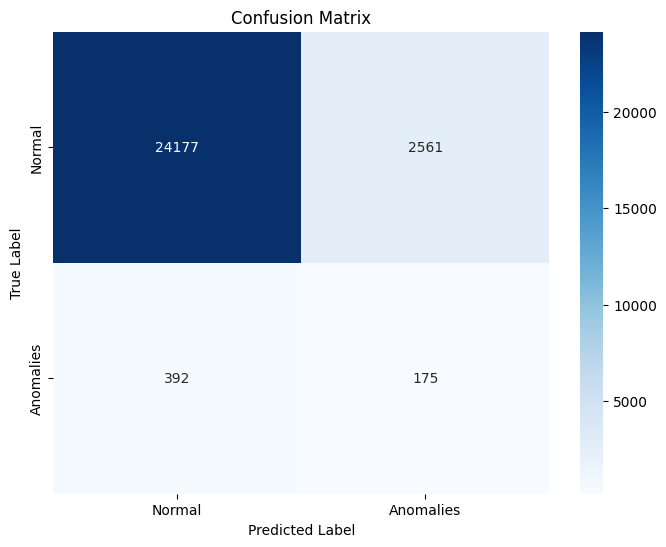


Generating SHAP explanations...


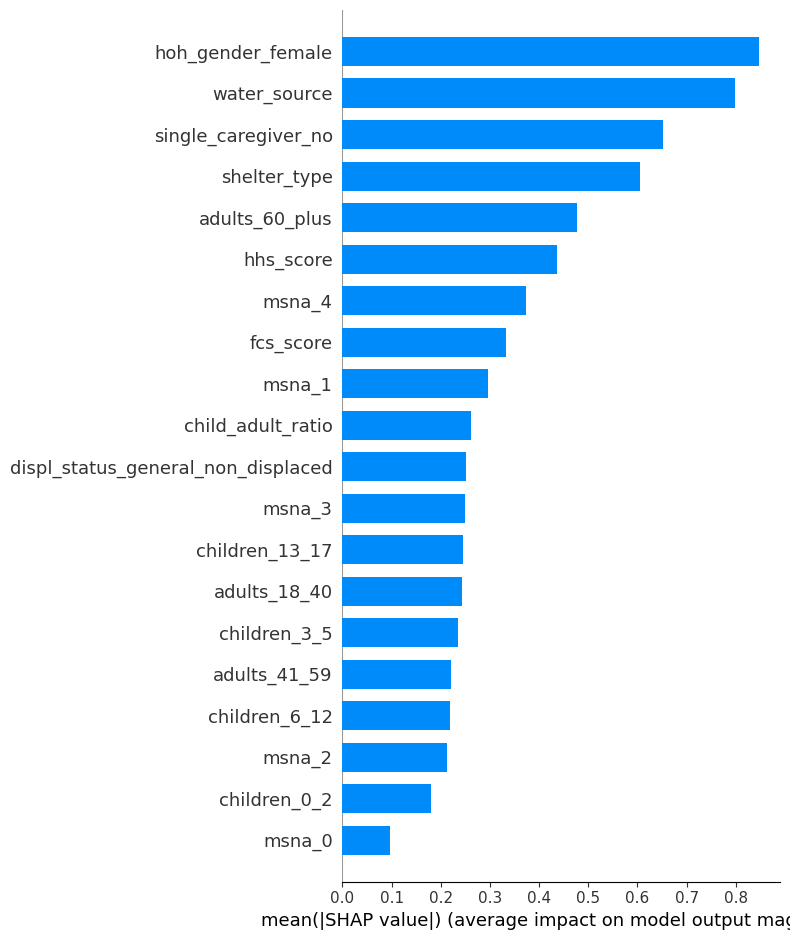

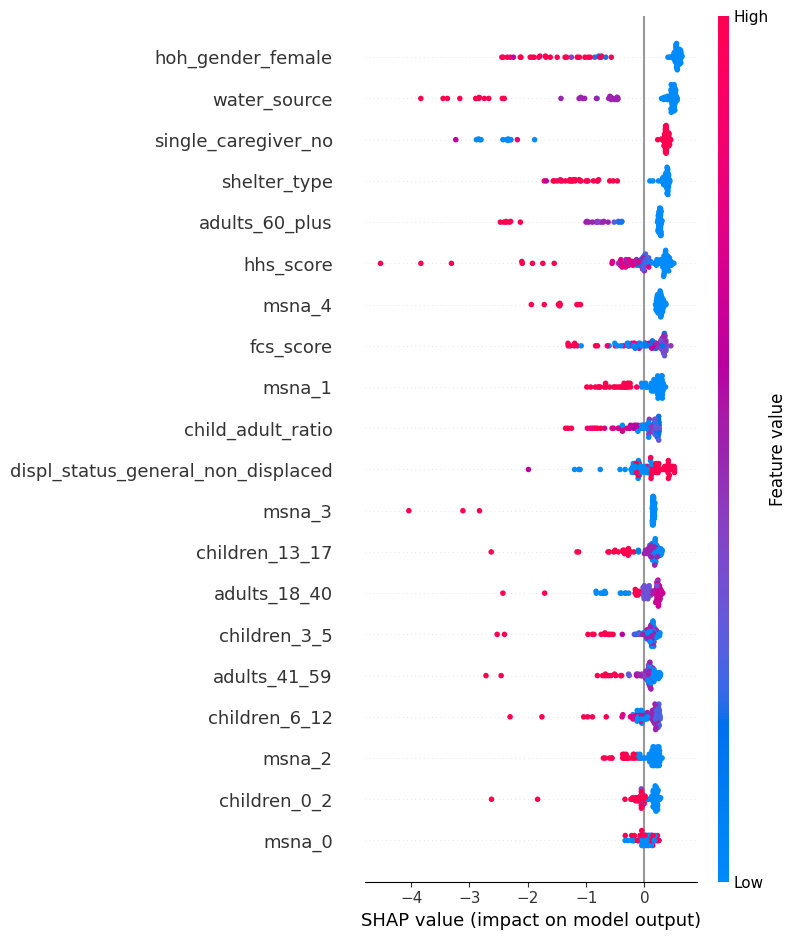

<Figure size 1200x500 with 0 Axes>

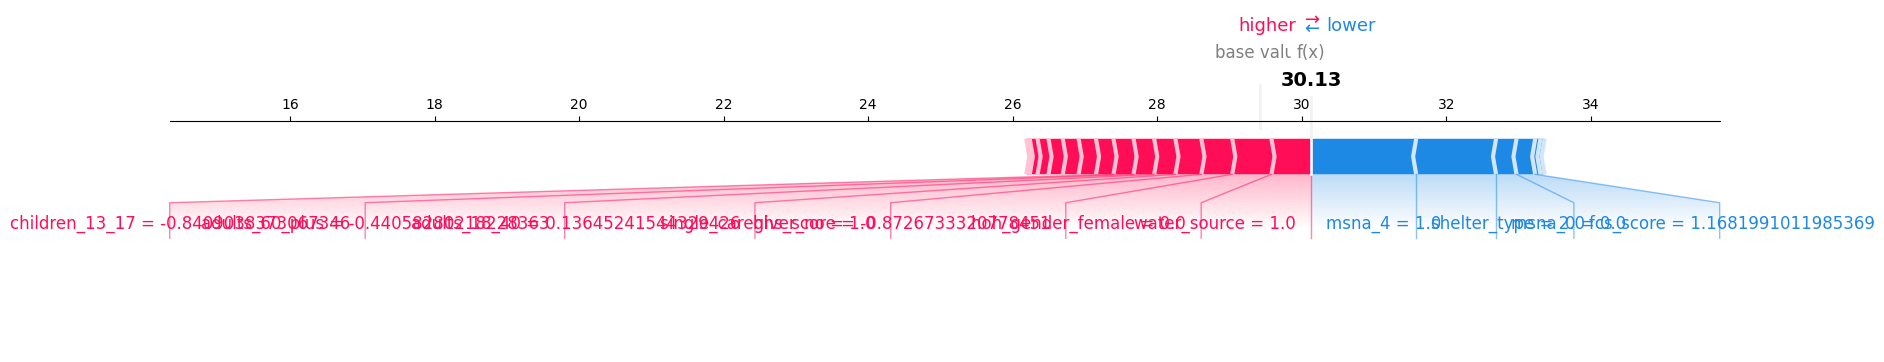

<Figure size 640x480 with 0 Axes>

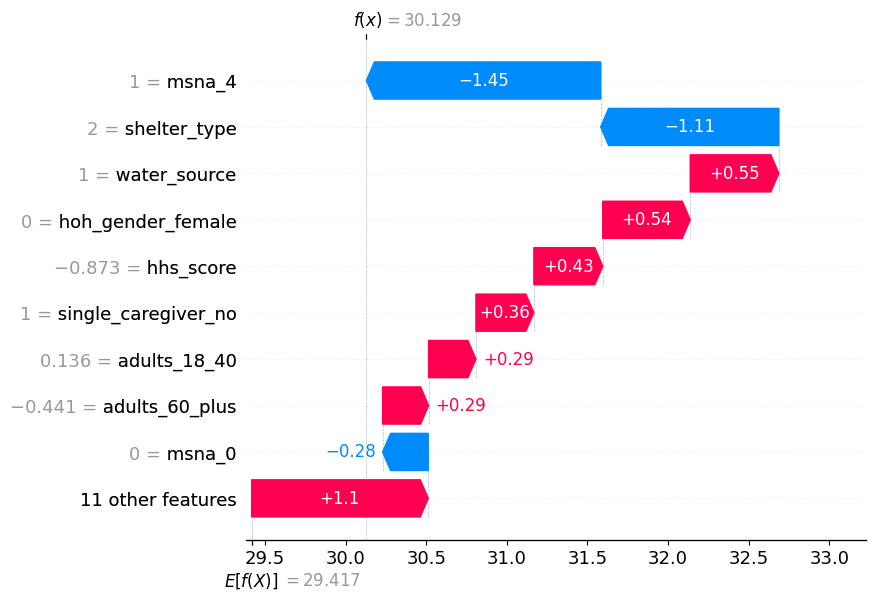

In [3]:
import pickle 
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix

# Load best model
def load_best_model():
    with open('best_model.pkl', 'rb') as f:
        best_model = pickle.load(f)
    return best_model

# Load test data
def load_test_data():
    with open('X_test.pkl', 'rb') as f:
        X_test = pickle.load(f)
    with open('y_test.pkl', 'rb') as f:
        y_test = pickle.load(f)
    return X_test, y_test

# Ensure test data has the same columns as training data
def align_test_data(X_test, model):
    training_columns = model.feature_names_in_
    X_test_aligned = X_test.reindex(columns=training_columns, fill_value=0)
    return X_test_aligned

# Evaluate best model on test data and plot SHAP values
def evaluate_on_test(model, X_test, y_test):
    X_test = align_test_data(X_test, model)
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred == -1, 1, 0)  # Convert -1 to 1 for anomalies and 1 to 0 for normal

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_binary)
    auc_pr = auc(recall, precision)
    print(f"Precision-Recall AUC: {auc_pr:.4f}")
    
    # Print Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary, digits=4))

    # Plot Confusion Matrix
    plot_confusion_matrix(y_test, y_pred_binary)

    # SHAP explanation
    if hasattr(model, 'predict_proba') or hasattr(model, 'decision_function'):
        plot_shap_values(model, X_test)

# Plot a state-of-the-art confusion matrix using seaborn
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomalies'], yticklabels=['Normal', 'Anomalies'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_plot.png', bbox_inches='tight')  # Export the confusion matrix
    plt.show()  # Show the confusion matrix plot
    plt.close()

# Plot SHAP values with additional plots (summary, beeswarm, force, waterfall)
def plot_shap_values(model, X_test):
    print("\nGenerating SHAP explanations...")

    # Sample the test data for faster SHAP calculations
    X_sample = X_test.sample(n=100, random_state=42)  # Limit to 100 samples to speed up SHAP

    # Initialize SHAP explainer for tree-based models like IsolationForest
    explainer = shap.TreeExplainer(model)

    # Get SHAP values as Explanation object
    shap_values = explainer(X_sample)

    # SHAP Summary Plot: Feature Importance (bar plot)
    plt.figure()  # Ensure a new figure for each plot
    shap.summary_plot(shap_values.values, X_sample, plot_type="bar", show=False)
    plt.savefig('shap_summary_bar_plot.png', bbox_inches='tight')  # Save the SHAP summary bar plot
    plt.show()  # Show the SHAP summary plot
    plt.close()

    # SHAP Beeswarm Plot: Displays the importance of features across the dataset
    plt.figure()  # New figure
    shap.summary_plot(shap_values.values, X_sample, plot_type="dot", show=False)  # Beeswarm is a "dot" type plot
    plt.savefig('shap_beeswarm_plot.png', bbox_inches='tight')  # Save the SHAP beeswarm plot
    plt.show()  # Show the SHAP beeswarm plot
    plt.close()

    # SHAP Force Plot: Single instance explanation (for the first sample)
    plt.figure(figsize=(12, 5))  # Set figure size for the force plot
    shap.force_plot(shap_values[0].base_values, shap_values[0].values, X_sample.iloc[0], matplotlib=True)
    plt.savefig('shap_force_plot.png', bbox_inches='tight')  # Save the SHAP force plot
    plt.show()  # Show the SHAP force plot
    plt.close()

    # SHAP Waterfall Plot: Visualizes the contribution of each feature to the final prediction for one instance
    plt.figure()  # New figure
    shap.waterfall_plot(shap_values[0], show=False)
    plt.savefig('shap_waterfall_plot.png', bbox_inches='tight')  # Save the SHAP waterfall plot
    plt.show()  # Show the SHAP waterfall plot
    plt.close()

if __name__ == '__main__': 
    print("Loading the best model...")
    model = load_best_model()

    # Load the test set (fixing the undefined X_test)
    print("\nLoading test set...")
    X_test, y_test = load_test_data()

    # Evaluate the best model on the test set
    evaluate_on_test(model, X_test, y_test)


## 11. Interpretation